# Importaciones

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [2]:
# Kaggle: https://www.kaggle.com/competitions/diamonds-part-datamad0122/
# Origen: Tiffany & Co's snapshot pricelist from 2017
df_train = pd.read_csv(r'..\data\raw\train.csv')
df_test = pd.read_csv(r'..\data\raw\test.csv')

df_base = pd.concat([df_train, df_test]).reset_index().drop(columns=['index', 'id'])

# Observaciones iniciales

In [3]:
df_base.head()


,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [4]:
# Adaptamos los nombres de las columnas para que sean legibles y borramos la primera porque no sirve
df_base = df_base.rename(columns={'carat': 'weight (carat)',
                                                'cut': 'cut quality',
                                                'color': 'color quality',
                                                'clarity': 'clarity quality', # Fuente: https://4cs.gia.edu/en-us/diamond-clarity/
                                                'depth': 'depth (percentage)', # Medida de la altura ("depth") del diamante en relación a su diámetro. Fuente: https://www.withclarity.com/education/diamond-education/diamond-cut/what-is-diamond-depth-or-diamond-education
                                                'table': 'table (percentage)', # Medida de la parte plana ("table") del diamante en relación a su diámetro. Fuente: https://www.brilliance.com/education/diamonds/depth-table
                                                'price': 'price (dollars)',
                                                'x': 'lenght (millimeters)', # Visto desde arriba, longitud de un costado del diamante. Su media con "width" da el diámetro
                                                'y': 'width (millimeters)', # Visto desde arriba, longitud del otro costado
                                                'z': 'depth (millimeters)' # Altura (distancia entre la punta y la parte plana)
                                                }
                                )


In [5]:
df_base.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price (dollars)
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [6]:
# No hay valores nulos fuera del target
df_base.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weight (carat)        53940 non-null  float64
 1   cut quality           53940 non-null  object 
 2   color quality         53940 non-null  object 
 3   clarity quality       53940 non-null  object 
 4   depth (percentage)    53940 non-null  float64
 5   table (percentage)    53940 non-null  float64
 6   lenght (millimeters)  53940 non-null  float64
 7   width (millimeters)   53940 non-null  float64
 8   depth (millimeters)   53940 non-null  float64
 9   price (dollars)       40455 non-null  float64
dtypes: float64(7), object(3)
memory usage: 4.1+ MB


In [7]:
# No parece posible que haya diamantes con 0 milimetros de altura, anchura o profundidad. Quizá lo que ocurra es que son tan redondos que no cabe medir algunos datos. Habrá que revisarlo
df_base.describe()


,weight (carat),depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price (dollars)
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,40455.000000
mean,0.797940,61.749405,57.457184,5.731157,5.734526,3.538734,7.783822
std,0.474011,1.432621,2.234491,1.121761,1.142135,0.705699,1.016828
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,5.787000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,6.851000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,7.780000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,8.581000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,9.842000


In [8]:
df_base.describe(include='object')


,cut quality,color quality,clarity quality
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


In [9]:
# Hay muchos valores duplicados
df_base[df_base.duplicated()]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price (dollars)
2746,0.43,Ideal,G,VS1,61.9,55.0,4.84,4.86,3.00,6.849
7158,0.35,Premium,J,VS1,62.4,58.0,5.67,5.64,3.53,6.855
7672,0.41,Ideal,G,IF,61.7,56.0,4.77,4.80,2.95,7.220
8184,1.00,Fair,F,SI2,65.1,55.0,6.26,6.23,4.07,8.091
9493,2.00,Premium,G,SI2,60.7,60.0,8.13,8.07,4.92,9.290
...,...,...,...,...,...,...,...,...,...,...
49713,1.50,Fair,H,SI1,65.0,57.0,7.10,7.06,4.60,NaN
51138,0.32,Good,F,VVS1,63.8,54.0,4.38,4.31,2.77,NaN
52023,0.70,Premium,F,VVS2,62.6,59.0,5.66,5.62,3.53,NaN
52903,0.33,Ideal,F,IF,61.2,56.0,4.47,4.49,2.74,NaN


In [10]:
# Hay que eliminar los duplicados. Copiamos el "dataframe" para poder trabajar con varias versiones si conviene
df_diamonds = df_base.copy().drop_duplicates()
df_diamonds[df_diamonds.duplicated()]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price (dollars)


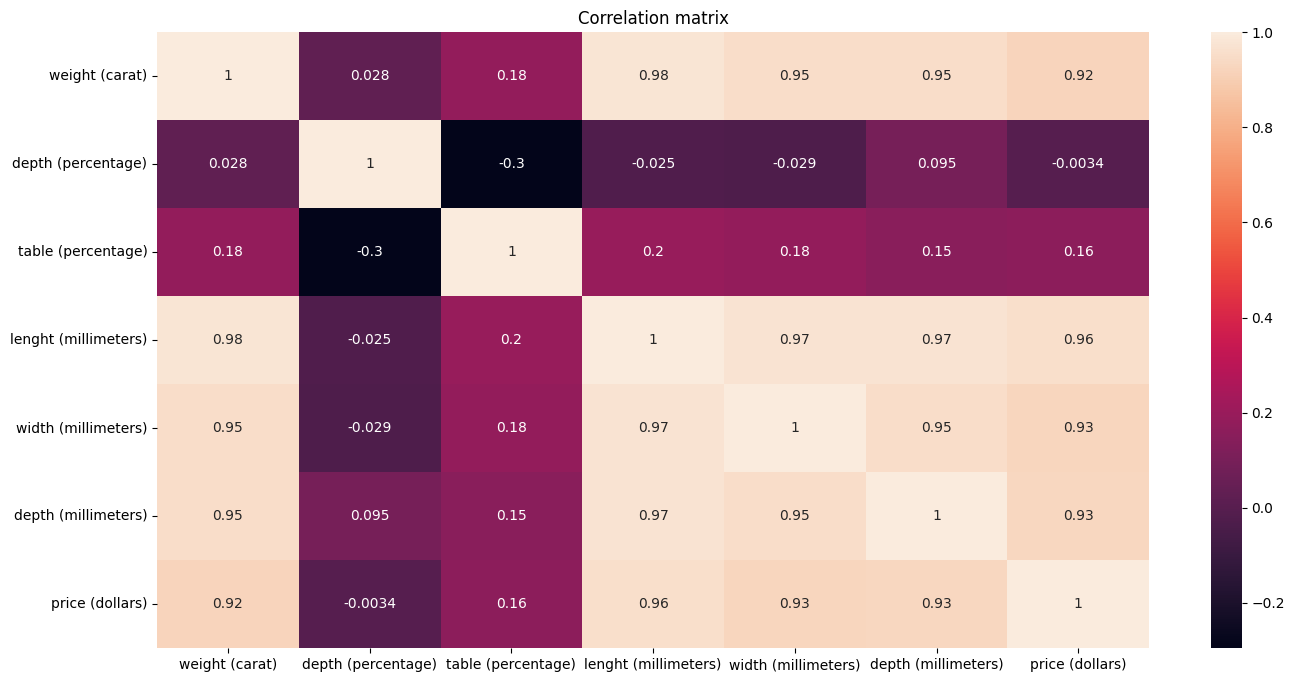

In [11]:
# Hacemos una correlación preeliminar (sin análisis) que nos servirá para detectar errores, si los hay, durante la limpieza
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [12]:
plt.rc("figure", figsize=(6.4, 4.8))


In [13]:
# Separamos el target del resto del "dataframe" para trabajar con más comodidad
df_price, df_diamonds = df_base['price (dollars)'], df_base.drop(columns='price (dollars)')

# Desglose por columnas

## weight (carat)

In [14]:
df_diamonds['weight (carat)'].unique()


array([0.3 , 1.01, 0.72, 1.08, 0.36, 0.53, 1.74, 0.33, 0.32, 0.27, 0.63,
       0.31, 0.7 , 0.74, 1.29, 0.71, 0.52, 0.42, 1.06, 0.58, 1.5 , 1.  ,
       0.51, 1.2 , 0.41, 1.12, 1.22, 0.5 , 0.56, 2.53, 0.37, 1.7 , 0.54,
       0.34, 1.61, 0.38, 0.61, 1.21, 1.28, 1.26, 0.4 , 0.81, 0.76, 0.44,
       1.03, 0.6 , 1.1 , 0.78, 1.13, 0.77, 2.09, 0.35, 0.39, 0.9 , 1.84,
       0.79, 1.07, 1.58, 2.01, 2.  , 1.27, 1.51, 0.62, 1.68, 0.66, 1.17,
       1.56, 1.11, 0.24, 1.05, 1.65, 1.47, 2.08, 1.55, 0.55, 1.04, 1.02,
       0.43, 0.59, 0.25, 2.03, 1.25, 0.94, 1.54, 1.59, 0.26, 0.8 , 1.76,
       1.63, 1.24, 1.34, 1.52, 2.22, 0.47, 2.25, 1.39, 0.46, 0.45, 0.92,
       0.23, 1.72, 0.91, 1.53, 1.19, 0.73, 0.75, 0.29, 0.28, 1.33, 2.33,
       1.41, 1.31, 1.43, 0.93, 1.09, 1.3 , 1.73, 1.99, 1.35, 1.46, 1.71,
       1.14, 0.96, 1.15, 1.18, 1.69, 0.83, 0.57, 1.23, 2.05, 2.26, 1.6 ,
       2.12, 2.21, 2.02, 2.14, 2.06, 1.32, 1.75, 1.57, 2.74, 2.16, 2.42,
       0.97, 1.66, 1.38, 1.67, 0.65, 2.5 , 1.16, 2.

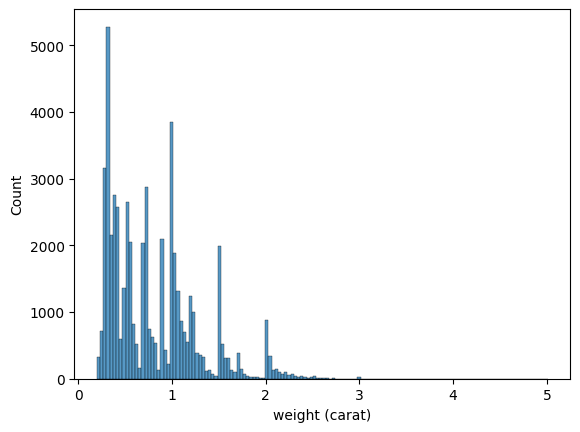

In [15]:
# Hay muy pocos diamantes que pesen más de 2 "carat" (quilates)
sns.histplot(df_diamonds['weight (carat)'])
plt.show()


In [16]:
# No hay valores que sean cero
df_diamonds[df_diamonds['weight (carat)'] == 0] 


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)


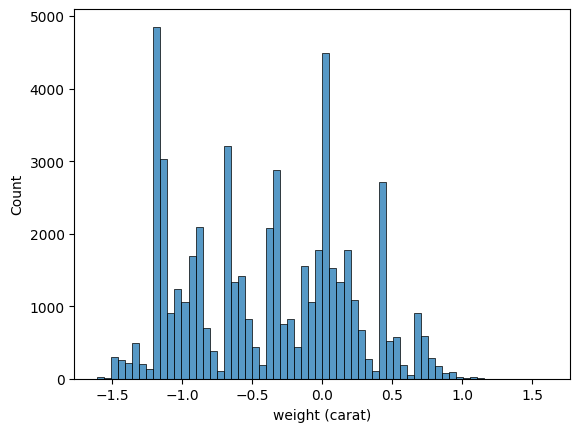

In [17]:
# Está muy a la izquierda. Utilizamos el logaritmo para centrarlo
df_diamonds['weight (carat)'] = np.log(df_diamonds['weight (carat)'])

sns.histplot(df_diamonds['weight (carat)'])
plt.show()


### "Outliers" tratados

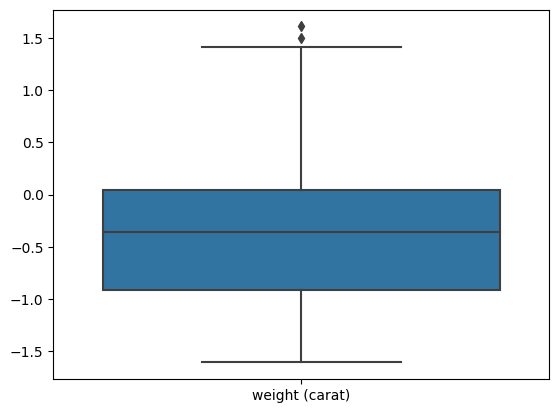

In [18]:
# Confirmamos con un boxplot que quedan solo un par de valores atípicos
ax = sns.boxplot(df_diamonds['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


In [19]:
# Como están cerca del máximo del boxplot, los imputamos a esa cifra
q3, q1 = np.percentile(df_diamonds['weight (carat)'], [75, 25])
iqr = q3 - q1

df_diamonds.loc[df_diamonds['weight (carat)'] > q3 + 1.5*iqr, 'weight (carat)'] = q3 + 1.5*iqr


## cut quality

In [20]:
# No es numérica, habrá que transformarla. 
cut_uniques = list(df_diamonds['cut quality'].unique())
cut_uniques


['Premium', 'Ideal', 'Very Good', 'Fair', 'Good']

In [21]:
# Utilizamos valores cercanos a 0 para que, al tipificar otras columnas, no se alejen demasiado
very_good = cut_uniques[3]
cut_uniques.remove(very_good)
cut_uniques.insert(2, very_good)

for word, value in zip(reversed(cut_uniques), [-1.0, -0.5, 0.0, 0.5, 1.0]):
    df_diamonds.loc[df_diamonds['cut quality'] == word, 'cut quality'] = value
    print(word, value)


Good -1.0
Very Good -0.5
Fair 0.0
Ideal 0.5
Premium 1.0


In [22]:
df_diamonds['cut quality'] = df_diamonds['cut quality'].astype(float)

df_diamonds['cut quality'].unique()


array([ 1. ,  0.5, -0.5,  0. , -1. ])

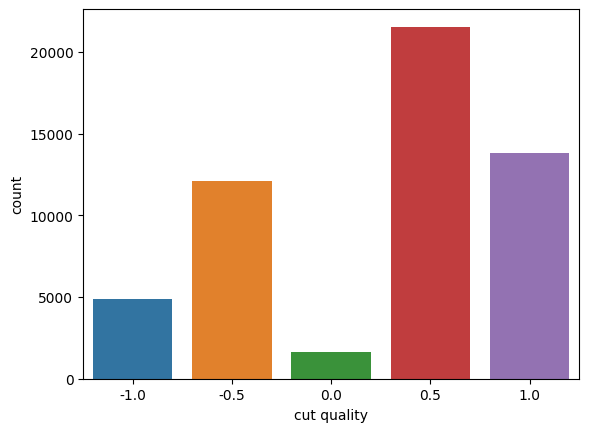

In [23]:
# Están bastente repartidos, aunque hay menos de categoría "Good" (-0.5) o inferior
sns.countplot(x=df_diamonds['cut quality'])
plt.show()


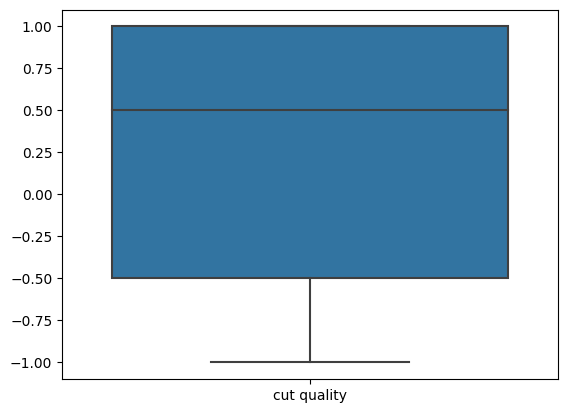

In [24]:
# En efecto, no hay "outliers"
ax = sns.boxplot(df_diamonds['cut quality'])
ax.set_xticklabels(['cut quality'])
plt.show()


## color quality

In [25]:
color_uniques = list(df_diamonds['color quality'].unique())
color_uniques.sort(reverse=True)
color_uniques


['J', 'I', 'H', 'G', 'F', 'E', 'D']

In [26]:
# Similar al anterior, hay que pasar los valores a numéricos (J es la peor calidad, y D es la mejor)
for character, value in zip(color_uniques, [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]):
    df_diamonds.loc[df_diamonds['color quality'] == character, 'color quality'] = value
    print(character, value)


J -1.5
I -1.0
H -0.5
G 0.0
F 0.5
E 1.0
D 1.5


In [27]:
df_diamonds['color quality'] = df_diamonds['color quality'].astype(float)

df_diamonds['color quality'].unique()


array([ 1.5,  1. ,  0.5,  0. , -0.5, -1. , -1.5])

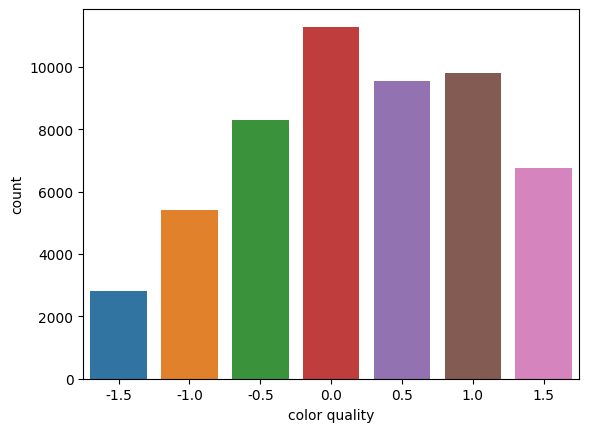

In [28]:
# Están repartidos, si bien hay pocos de calidad J (-1.5)
sns.countplot(x=df_diamonds['color quality'])
plt.show()


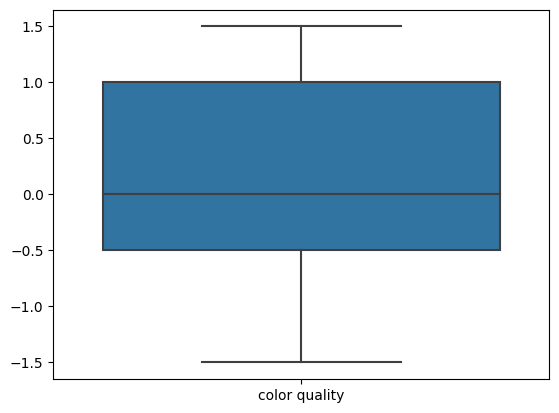

In [29]:
# Sin valores atípicos
ax = sns.boxplot(df_diamonds['color quality'])
ax.set_xticklabels(['color quality'])
plt.show()


## clarity quality

In [30]:
# Hay que buscar a qué nivel de calidad corresponde cada valor y numerarlos
df_diamonds['clarity quality'].unique()


array(['SI2', 'VVS2', 'VS2', 'VS1', 'SI1', 'VVS1', 'IF', 'I1'],
      dtype=object)

In [31]:
# Fuente: https://www.77diamonds.com/es/grados-de-pureza-del-diamante
df_diamonds['clarity quality'] = df_diamonds['clarity quality'].apply(lambda x: -1.5 if x == 'I1'
                                                                        else -1.0 if x == 'SI2'
                                                                        else -0.5 if x == 'SI1'
                                                                        else -0.0 if x == 'VS2'
                                                                        else 0.5 if x == 'VS1'
                                                                        else 1.0 if x == 'VVS2'
                                                                        else 1.5 if x == 'VVS1'
                                                                        else 2.0
                                                                        )

df_diamonds['clarity quality'].unique()


array([-1. ,  1. , -0. ,  0.5, -0.5,  1.5,  2. , -1.5])

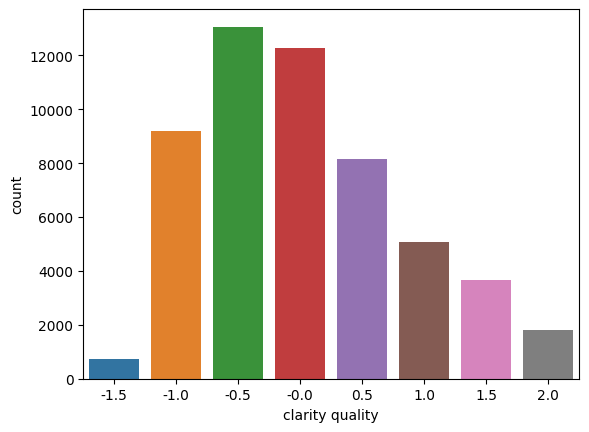

In [32]:
# Tal como indica la fuente, los diamantes de máxima calidad son muy raros. Hay menos, todavía, de la peor calidad
sns.countplot(x=df_diamonds['clarity quality'])
plt.show()


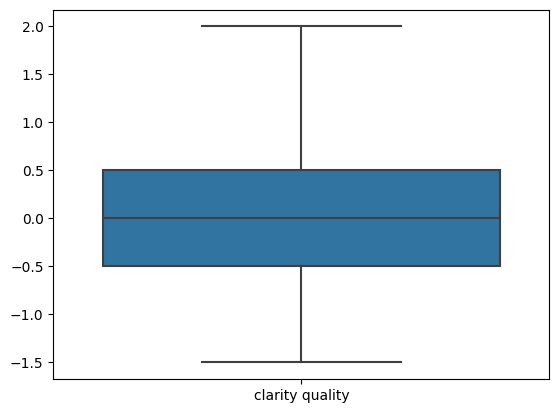

In [33]:
# Con todo, no hay "outliers"
ax = sns.boxplot(df_diamonds['clarity quality'])
ax.set_xticklabels(['clarity quality'])
plt.show()


## depth (percentage)

In [34]:
df_diamonds['depth (percentage)'].unique()


array([62.4, 62.7, 61.8, 63.2, 62.3, 61.4, 62.1, 60. , 62.9, 61.1, 62. ,
       62.2, 62.8, 61.6, 59.3, 61.7, 56.7, 65.3, 58.2, 61.9, 60.9, 61.5,
       63.4, 63.1, 64.9, 61.3, 63. , 60.6, 61.2, 59. , 62.5, 59.8, 63.3,
       61. , 63.9, 62.6, 57.2, 63.5, 60.7, 59.7, 59.1, 58.5, 58.4, 58.9,
       60.4, 59.9, 60.8, 59.2, 60.5, 60.2, 64.1, 63.6, 66.7, 59.6, 58. ,
       66.6, 58.7, 65.5, 57.7, 60.1, 64.6, 66.3, 64.2, 63.8, 58.1, 55.1,
       67.1, 64.3, 65.8, 58.8, 67. , 63.7, 59.5, 64. , 64.7, 67.4, 66.1,
       57.4, 59.4, 58.6, 60.3, 58.3, 57.3, 65. , 65.2, 64.4, 57.6, 57.8,
       65.4, 65.7, 66.4, 67.6, 64.8, 53.2, 64.5, 65.9, 65.1, 66.9, 69. ,
       66.5, 56.3, 67.2, 65.6, 68.5, 55.2, 57.9, 56.1, 56.9, 55.3, 56.5,
       55.9, 57.1, 69.7, 56.8, 57.5, 57. , 66. , 66.2, 71.8, 68.2, 55.8,
       66.8, 67.7, 68.1, 72.9, 67.8, 68.3, 68.6, 53.3, 67.3, 51. , 68. ,
       56.4, 55.5, 71. , 68.4, 53. , 56. , 54.2, 69.4, 53.8, 67.5, 56.2,
       69.2, 55.4, 70.2, 69.9, 68.8, 56.6, 72.2, 68

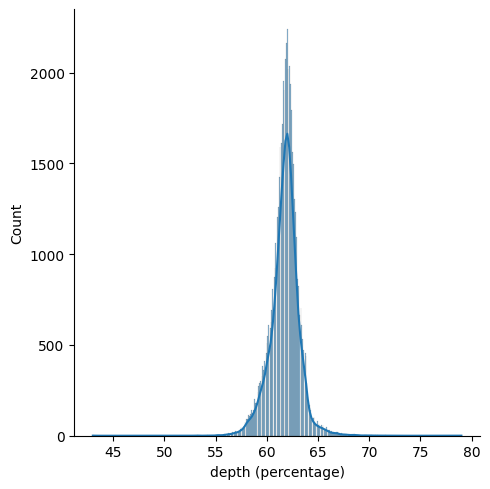

In [35]:
# Si no fuera porque el grueso de los números se encuentra en el centro, se asemejaría bastante a una distribución normal
sns.displot(df_diamonds['depth (percentage)'], kde=True)
plt.show()


### "Outliers" tratados en: "Desglose por múltiples variables"

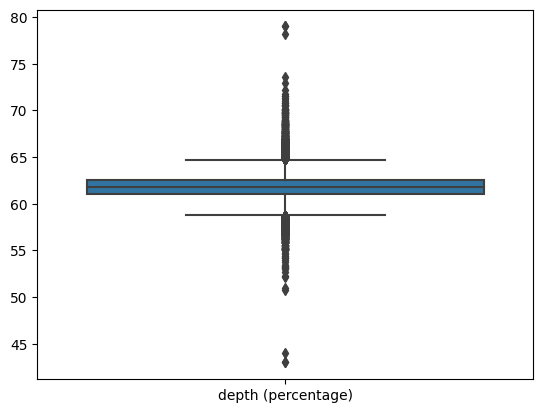

In [36]:
# A consecuencia de ello, hay muchos "outliers". Se nota la concentración en el centro
ax = sns.boxplot(df_diamonds['depth (percentage)'])
ax.set_xticklabels(['depth (percentage)'])
plt.show()


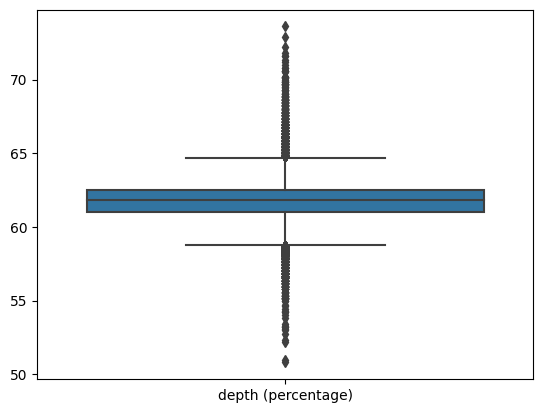

In [37]:
# Liquidamos esos cuatro "outliers" exageradamente altos
df_diamonds = df_diamonds.drop(df_diamonds[(df_diamonds['depth (percentage)'] > 75) | (df_diamonds['depth (percentage)'] < 45)].index)

ax = sns.boxplot(df_diamonds['depth (percentage)'])
ax.set_xticklabels(['depth (percentage)'])
plt.show()


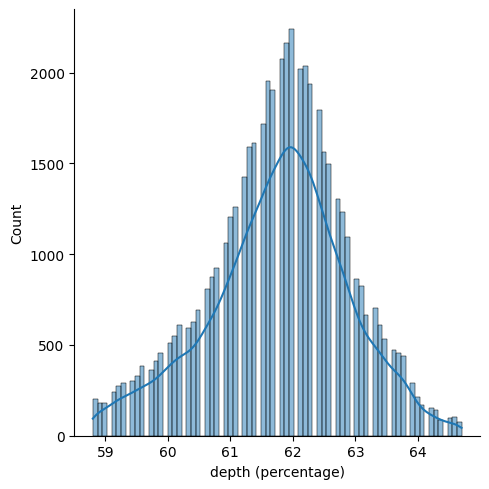

In [38]:
# Repetimos la gráfica de densidad, pero, esta vez, filtramos los valores atípicos para una mejor visualización
q3, q1 = np.percentile(df_diamonds['depth (percentage)'], [75, 25])
iqr = q3 - q1

df_depth_filtered = df_diamonds[(df_diamonds['depth (percentage)'] <= q3 + 1.5*iqr) & (df_diamonds['depth (percentage)'] >= q1 - 1.5*iqr)]

sns.displot(df_depth_filtered['depth (percentage)'], kde=True)
plt.show()


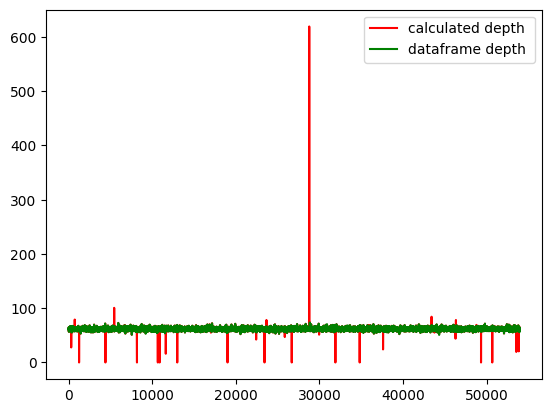

In [39]:
# Según el autor del "dataset" en Kaggle, la variable "depth (percentage)" sale de dividir "depth (millimeters)" por la media de "lenght (millimeters)" y "width (millimeters)"
# Por tanto, si hacemos la operación, el resultado debería coincidir con la columna de "depth (percentage)"
# Notamos que no coinciden, y que la versión incluida en el "dataset" parece no tener en cuenta varios valores que se considerarían my atípicos
# Para futuras pruebas de modelo, quizá convendrá tener en cuenta los valores calculados en lugar de los que vienen dados por defecto
calculated_depth = (df_diamonds['depth (millimeters)'] / ((df_diamonds['lenght (millimeters)']+df_diamonds['width (millimeters)']) / 2)) * 100
depth_comparison = pd.DataFrame({'calculated depth ': calculated_depth, 'dataframe depth': df_diamonds['depth (percentage)']})

depth_comparison.plot(kind='line', color=['red', 'green'])
plt.show()


## table (percentage)

In [40]:
df_diamonds['table (percentage)'].unique()


array([58. , 56. , 59. , 57. , 55. , 62. , 53. , 63. , 61. , 54. , 60. ,
       64. , 65. , 55.1, 58.1, 53.6, 66. , 57.9, 68. , 56.5, 55.5, 56.6,
       55.6, 54.7, 54.8, 53.7, 54.1, 56.4, 51.6, 52. , 54.5, 57.2, 69. ,
       54.6, 54.2, 56.1, 55.9, 55.4, 59.7, 57.6, 67. , 59.9, 53.4, 60.1,
       58.2, 57.5, 53.8, 54.9, 57.8, 60.5, 56.3, 58.4, 60.3, 57.7, 60.7,
       53.5, 57.1, 61.2, 55.2, 53.9, 54.4, 56.9, 59.8, 58.6, 57.4, 59.2,
       70. , 62.4, 61.5, 55.7, 52.8, 56.8, 53.2, 61.6, 51. , 62.3, 60.2,
       49. , 57.3, 59.1, 62.5, 59.4, 55.8, 56.7, 71. , 56.2, 60.6, 55.3,
       54.3, 62.2, 62.8, 53.3, 59.5, 50.1, 59.6, 58.8, 63.4, 61.7, 65.4,
       76. , 44. , 60.4, 60.9, 61.9, 79. , 58.5, 58.9, 61.4, 50. , 61.3,
       58.3, 62.6, 53.1, 63.5, 60.8, 63.3, 61.1, 64.3, 95. , 73. , 59.3,
       58.7, 64.2, 61.8, 62.1, 43. , 52.4])

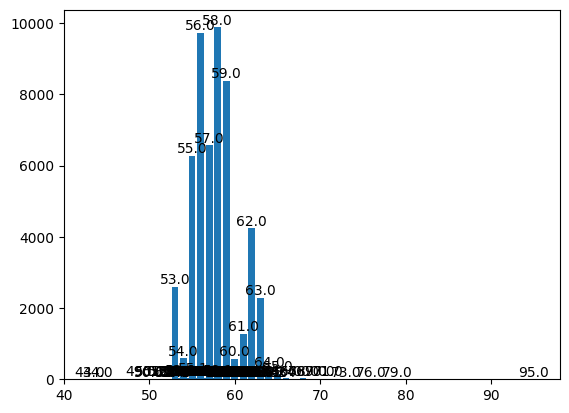

In [41]:
# Vemos que la inmensa mayoría se encuentran entre 50% y 65%, con números distintos, y que hay unos pocos valores que se repiten mucho
# Detectamos también un "outlier" flagrante del 95%
barplot = plt.bar(x=df_diamonds['table (percentage)'].unique(), height=df_diamonds['table (percentage)'].value_counts())
plt.bar_label(barplot, labels=df_diamonds['table (percentage)'].unique(), label_type='edge')
plt.show()


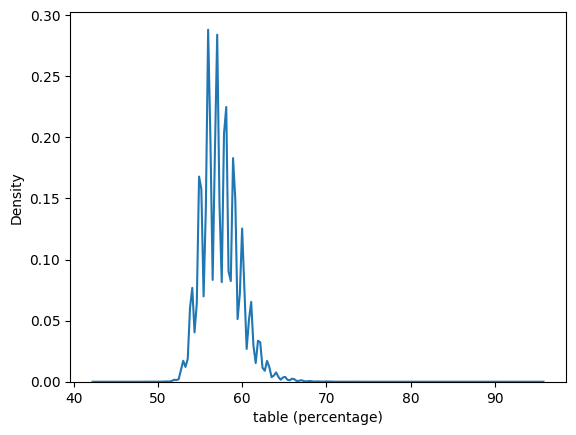

In [42]:
# Visualizamos su gráfica de densidad
sns.kdeplot(df_diamonds['table (percentage)'])
plt.show()


### "Outliers" tratados en: "Desglose por múltiples variables"

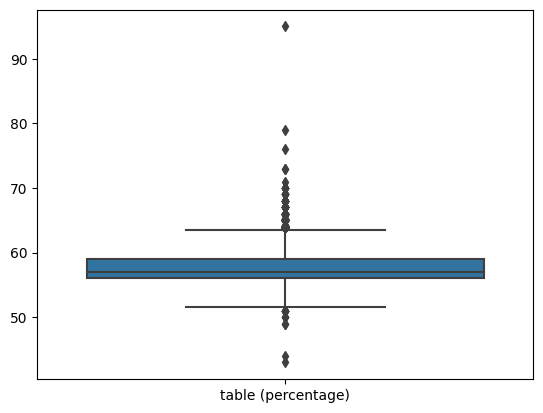

In [43]:
# Como es de preveer hay muchos "outliers", sobre todo por la parte superior, y una concentración importante entre 55% y 60%
ax = sns.boxplot(df_diamonds['table (percentage)'])
ax.set_xticklabels(['table (percentage)'])
plt.show()


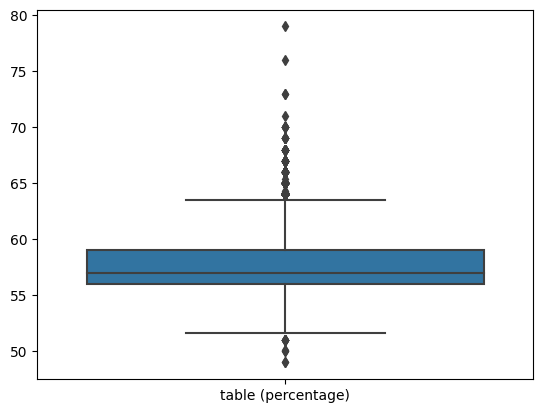

In [44]:
# Hay un solo valor muy alto y dos muy bajos. Nos podemos permitir eliminarlos
df_diamonds = df_diamonds.drop(df_diamonds[(df_diamonds['table (percentage)'] > 90) | (df_diamonds['table (percentage)'] < 45)].index)

ax = sns.boxplot(df_diamonds['table (percentage)'])
ax.set_xticklabels(['table (percentage)'])
plt.show()


## price (dollars) - target

In [45]:
# Esta es la columna "target"
df_price.unique()


array([6.353, 9.183, 7.983, ..., 7.674, 5.852,   nan])

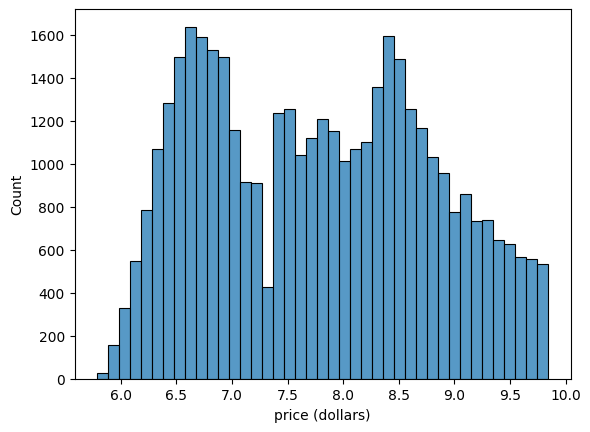

In [46]:
# Hay muchos diamantes con un precio "asequible", y cada vez menos a medida que se encarece
sns.histplot(df_price)
plt.show()


### "Outliers" tratados - "target"

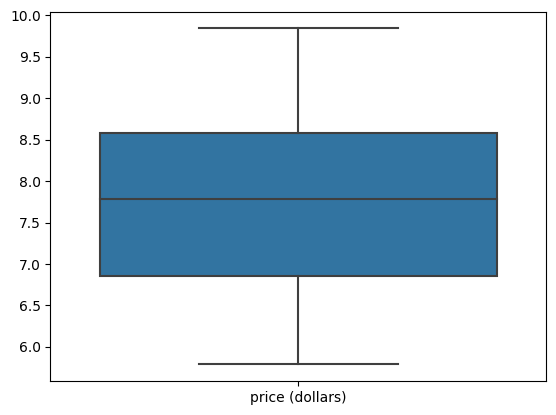

In [47]:
# Tiene valores atípicos en los precios superiores, y los números son muy altos comparados con el resto de columnas
# Le aplicamos un logaritmo para centrarlo, reducirlo y quitar los "outliers" sin eliminar realmente nada del "target"
ax = sns.boxplot(df_price)
ax.set_xticklabels(['price (dollars)'])
plt.show()


## lenght (millimeters)

In [48]:
df_diamonds['lenght (millimeters)'].unique()


array([ 4.31,  6.42,  5.71,  6.54,  4.5 ,  5.18,  7.69,  4.53,  4.36,
        4.16,  5.52,  4.34,  5.2 ,  5.67,  6.89,  4.38,  4.9 ,  5.38,
        7.52,  4.33,  6.28,  5.15,  7.04,  4.78,  4.84,  6.74,  6.86,
        5.06,  5.33,  4.42,  5.77,  4.3 ,  4.44,  8.82,  6.24,  4.64,
        7.59,  4.39,  5.14,  4.52,  6.82,  5.68,  7.68,  5.69,  5.24,
        6.38,  4.32,  6.3 ,  4.61,  4.8 ,  5.84,  5.66,  5.48,  6.84,
        6.96,  6.88,  4.72,  4.29,  5.94,  5.1 ,  4.93,  5.8 ,  6.46,
        5.64,  6.59,  5.82,  6.87,  5.9 ,  5.12,  8.51,  4.55,  7.  ,
        4.45,  5.07,  5.73,  4.56,  4.37,  5.25,  4.66,  6.64,  6.97,
        6.58,  7.29,  4.69,  6.34,  6.18,  8.01,  6.08,  7.46,  6.79,
        4.4 ,  4.35,  6.8 ,  5.6 ,  6.57,  5.01,  5.3 ,  4.87,  6.6 ,
        5.22,  6.11,  5.46,  7.02,  4.77,  4.49,  6.51,  7.55,  8.27,
        8.09,  6.94,  7.2 ,  5.16,  7.4 ,  5.51,  7.83,  5.21,  5.11,
        6.37,  6.15,  7.32,  6.72,  7.28,  6.14,  5.76,  7.39,  5.19,
        5.61,  6.62,

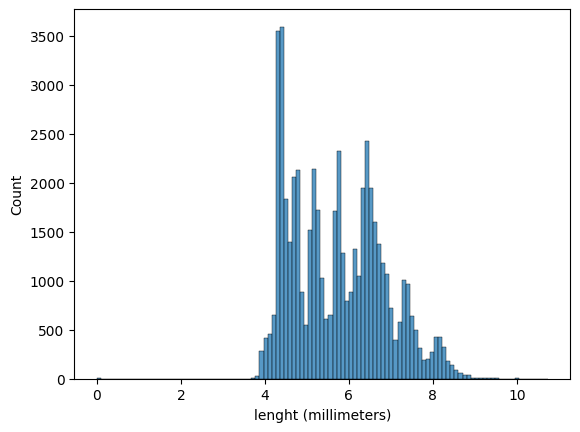

In [49]:
# Hay muchos valores únicos, así que usamos un histograma
# Claramente ese valor cercano a cero es un "outlier"
# Hay, además, unos pocos valores muy altos, cercanos a 10
sns.histplot(df_diamonds['lenght (millimeters)'])
plt.show()


In [50]:
# Si miramos esos ceros, vemos que, salvo uno, tampoco tenen width ni depth
df_diamonds[df_diamonds['lenght (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
3185,0.182322,1.0,1.5,1.5,62.1,59.0,0.0,0.00,0.0
4057,-0.342490,-1.0,0.5,-1.0,64.1,60.0,0.0,0.00,0.0
7910,0.000000,-0.5,-0.5,-0.0,63.3,53.0,0.0,0.00,0.0
8820,0.810930,1.0,-0.5,-1.0,62.8,59.0,0.0,0.00,0.0
13711,0.444686,0.5,0.0,-0.0,62.2,54.0,0.0,0.00,0.0
30214,-0.342490,-1.0,0.5,-1.0,64.1,60.0,0.0,0.00,0.0
34815,0.067659,0.5,0.5,-1.0,61.6,56.0,0.0,6.62,0.0
49241,0.131028,0.0,0.0,0.5,57.5,67.0,0.0,0.00,0.0


In [51]:
# Como esas tres variables son probablemente las que más influyen en el precio, eliminamos directamente los diamantes que solo tienen ceros para mayor precisión
df_diamonds = df_diamonds.drop(df_diamonds[(df_diamonds['lenght (millimeters)'] == 0) 
                                & (df_diamonds['width (millimeters)'] == 0)
                                & (df_diamonds['depth (millimeters)'] == 0)
                                            ].index
                                )

df_diamonds[df_diamonds['lenght (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
34815,0.067659,0.5,0.5,-1.0,61.6,56.0,0.0,6.62,0.0


In [52]:
# En cuanto al restante, comprobamos la relación entre las columnas "lenght" y "width"
# Como los diamantes son más o menos circulares, a priori, los números de "lenght" y "width" son bastante similares
# Fuente: https://www.diamondonnet.com/knowledges/help?sword=Length%20To%20Width%20Ratio
df_diamonds[['lenght (millimeters)','width (millimeters)']].head()


,lenght (millimeters),width (millimeters)
0,4.31,4.28
1,6.42,6.46
2,5.71,5.74
3,6.54,6.50
4,4.50,4.55


In [53]:
# Tanto es así que, excluyendo ese cero y redondeados, son exactamente iguales todos
all(df_diamonds['lenght (millimeters)'].drop(34815).apply(lambda x: round(x))) == all(df_diamonds['width (millimeters)'].drop(34815).apply(lambda x: round(x)))


True

In [54]:
# Suponemos, pues, que para ese diamente con cero son el mismo
# Por tanto, asignamos a ese cero la cifra correspondiente de la columna "width"
# Seguidamente, aplicamos el logaritmo
df_diamonds.loc[df_diamonds.index == 34815, 'lenght (millimeters)'] = 6.62
df_diamonds['lenght (millimeters)'] = np.log(df_diamonds['lenght (millimeters)'])

df_diamonds['lenght (millimeters)'].head()


0    1.460938
1    1.859418
2    1.742219
3    1.877937
4    1.504077
Name: lenght (millimeters), dtype: float64

### "Outliers" tratados

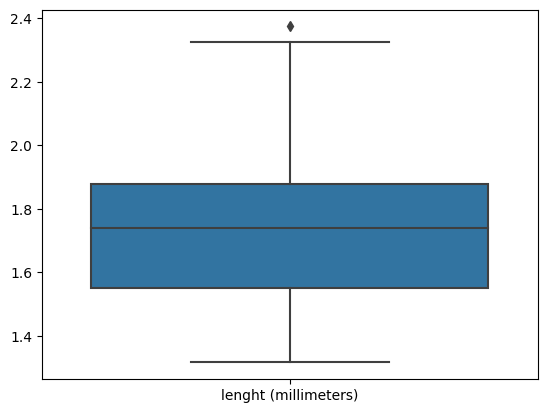

In [55]:
# Comprobamos que ya no quedan "outliers" por debajo de la mediana, y que queda uno por encima
ax = sns.boxplot(df_diamonds['lenght (millimeters)'])
ax.set_xticklabels(['lenght (millimeters)'])
plt.show()


In [56]:
# Sabemos que, por lo general, al tratarse de diamantes prácticamente circulares, el "lenght" y el "width" suelen ser muy parecidos
# Por tanto, imputamos ese valor atípico de "lenght" al "width" correspondiente para librarnos de él
q3, q1 = np.percentile(df_diamonds['lenght (millimeters)'], [75, 25])
iqr = q3 - q1

df_diamonds.loc[df_diamonds['lenght (millimeters)'] > q3 + 1.5*iqr, 'lenght (millimeters)'] = 2.355178


## width (millimeters)

In [57]:
df_diamonds['width (millimeters)'].unique()


array([ 4.28,  6.46,  5.74,  6.5 ,  4.55,  5.2 ,  7.63,  4.56,  4.39,
        4.12,  5.58,  4.37,  5.15,  5.72,  5.76,  6.93,  4.41,  5.22,
        4.92,  5.4 ,  7.57,  4.35,  6.25,  5.17,  6.95,  4.75,  4.8 ,
        6.66,  6.8 ,  4.31,  5.28,  4.46,  5.81,  6.51,  4.32,  4.45,
        8.76,  6.31,  4.6 ,  7.64,  4.34,  5.1 ,  4.57,  6.87,  5.75,
        6.83,  7.6 ,  5.73,  5.26,  6.35,  4.29,  6.38,  4.67,  4.77,
        5.8 ,  5.53,  6.9 ,  6.84,  4.66,  5.98,  4.38,  5.13,  5.87,
        4.88,  5.82,  6.43,  5.37,  5.67,  6.67,  5.7 ,  6.79,  5.85,
        5.08,  8.46,  4.52,  6.98,  4.43,  5.11,  4.27,  4.5 ,  5.23,
        4.69,  6.61,  7.01,  6.55,  7.19,  4.73,  6.44,  6.11,  7.98,
        6.06,  6.68,  4.4 ,  6.75,  5.63,  6.53,  4.48,  4.74,  5.07,
        5.12,  5.33,  4.84,  6.58,  6.02,  5.49,  6.96,  4.81,  7.5 ,
        8.2 ,  8.12,  7.16,  7.37,  5.46,  7.72,  5.24,  6.34,  6.99,
        5.14,  4.44,  5.38,  6.19,  7.27,  6.77,  7.32,  6.2 ,  7.46,
        5.65,  6.85,

### "Outliers" tratados

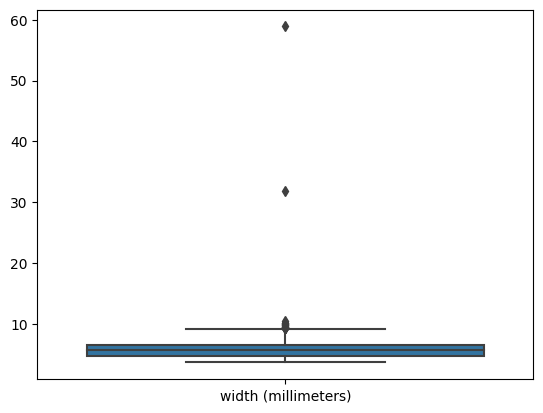

In [58]:
# En este caso están extremadamente concentrados, si bien hay unos pocos valores, poquísimos, superiores a 10
ax = sns.boxplot(df_diamonds['width (millimeters)'])
ax.set_xticklabels(['width (millimeters)'])
plt.show()


In [59]:
# Hay dos valores exageradamente altos. Los borramos. Con los que hemos eliminado antes en "lenght", ya no quedan ceros tampoco en "width"
df_diamonds = df_diamonds.drop(df_diamonds[df_diamonds['width (millimeters)'] > 30].index)

df_diamonds[df_diamonds['width (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)


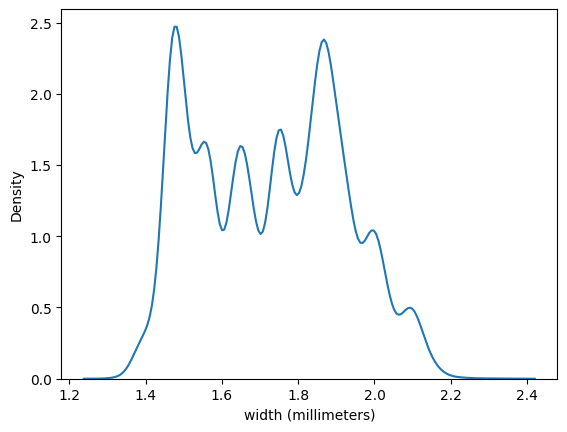

In [60]:
# Por tanto, podemos aplicar el logaritmo
df_diamonds['width (millimeters)'] = np.log(df_diamonds['width (millimeters)'])

sns.kdeplot(df_diamonds['width (millimeters)'])
plt.show()


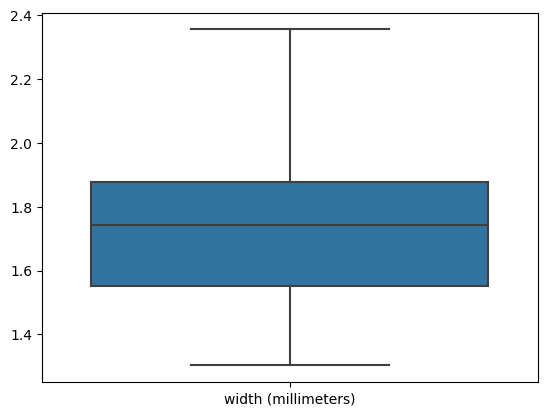

In [61]:
# Con lo hecho, ya no quedan valores atípicos
ax = sns.boxplot(df_diamonds['width (millimeters)'])
ax.set_xticklabels(['width (millimeters)'])
plt.show()


## depth (millimeters)

In [62]:
df_diamonds['depth (millimeters)'].unique()


array([ 2.68,  4.04,  3.54,  4.12,  2.82,  3.19,  4.76,  2.72,  2.75,
        2.56,  3.39,  2.67,  3.21,  3.58,  4.34,  3.56,  2.74,  3.2 ,
        2.91,  4.02,  3.36,  4.28,  2.69,  4.09,  3.17,  4.07,  2.97,
        4.15,  4.24,  3.11,  2.7 ,  3.26,  3.57,  4.14,  3.55,  5.37,
        2.83,  4.71,  3.5 ,  4.23,  4.51,  2.77,  3.23,  3.98,  2.66,
        3.59,  3.53,  3.29,  4.31,  2.93,  2.65,  3.7 ,  3.61,  2.99,
        4.05,  3.32,  3.68,  3.27,  4.85,  2.85,  4.27,  3.49,  2.64,
        3.24,  2.87,  4.06,  4.55,  2.89,  4.  ,  3.82,  4.77,  4.58,
        4.1 ,  4.26,  3.02,  2.9 ,  3.85,  3.34,  2.84,  2.76,  3.92,
        4.59,  4.93,  2.71,  4.3 ,  3.13,  3.41,  4.6 ,  3.22,  4.03,
        3.16,  3.44,  4.01,  3.3 ,  2.95,  3.83,  4.53,  4.16,  4.47,
        3.81,  3.52,  4.63,  3.18,  4.11,  4.29,  2.51,  2.94,  4.65,
        3.74,  3.71,  4.64,  5.02,  4.62,  3.48,  3.42,  3.96,  4.19,
        4.5 ,  3.  ,  3.99,  4.54,  3.51,  2.98,  2.96,  3.07,  2.6 ,
        3.66,  3.38,

In [63]:
# Empezamos por comprobar los ceros. Hay bastantes
df_diamonds[df_diamonds['depth (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
1249,0.810930,1.0,-1.0,-0.5,61.3,58.0,2.142416,2.130610,0.0
4401,0.095310,1.0,0.0,-1.0,63.0,59.0,1.871802,1.867176,0.0
8174,0.009950,1.0,0.5,-1.0,59.2,58.0,1.871802,1.867176,0.0
10669,0.405465,-1.0,0.0,-1.5,64.0,61.0,1.967112,1.951608,0.0
10881,0.009950,1.0,-0.5,-1.5,58.1,59.0,1.896119,1.887070,0.0
12992,0.703098,1.0,-0.5,-0.0,62.7,53.0,2.081938,2.073172,0.0
19007,1.029619,-1.0,0.0,-1.0,63.8,58.0,2.186051,2.180417,0.0
23431,0.788457,1.0,-0.5,-0.5,61.2,59.0,2.130610,2.124654,0.0
26686,0.113329,1.0,0.0,-1.5,60.4,59.0,1.903599,1.897620,0.0
31910,0.779325,1.0,-0.5,-1.0,59.4,61.0,2.138889,2.134166,0.0


In [64]:
# Sabemos que el "depth (percentage)" se obtiene de dividir su altura total ("depth") por el diámetro
# Como tenemos el "lenght" y el "width", el diámetro se obtiene con la media de esas dos cifras
# Por tanto, podemos resolver esos ceros con una operación

df_diamonds.loc[df_diamonds['depth (millimeters)'] == 0, 'depth (millimeters)'] = df_diamonds['depth (percentage)'] / 100 * (df_diamonds['lenght (millimeters)']+df_diamonds['width (millimeters)']) / 2

df_diamonds[df_diamonds['depth (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)


### "Outliers" tratados en: "Desglose por múltiples variables"

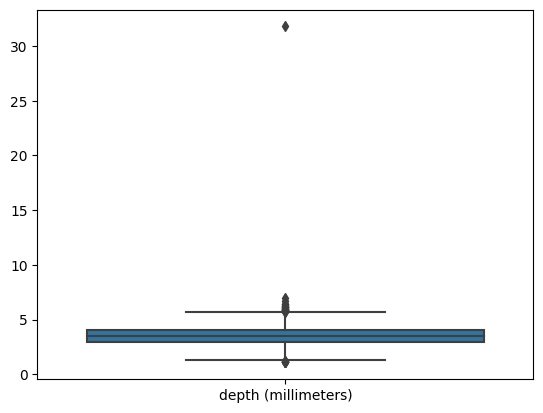

In [65]:
# Vemos que ya no hay ceros, que los valores están concentrados y que hay varios "outliers"; uno de ellos, muy alto
ax = sns.boxplot(df_diamonds['depth (millimeters)'])
ax.set_xticklabels(['depth (millimeters)'])
plt.show()


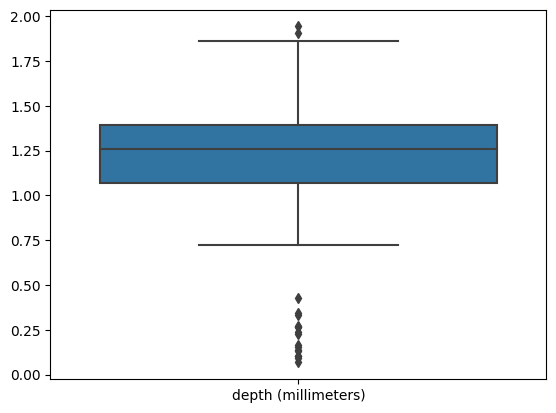

In [66]:
# Hay un solo valor exageradamente alto. Lo liquidamos y aplicamos el logaritmo para centrar la gráfica
df_diamonds = df_diamonds.drop(df_diamonds[df_diamonds['depth (millimeters)'] > 30].index)

df_diamonds['depth (millimeters)'] = np.log(df_diamonds['depth (millimeters)'])

ax = sns.boxplot(df_diamonds['depth (millimeters)'])
ax.set_xticklabels(['depth (millimeters)'])
plt.show()


# Desglose por múltiples variables

In [67]:
df_diamonds.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
0,-1.203973,1.0,1.5,-1.0,62.4,58.0,1.460938,1.453953,0.985817
1,0.009950,0.5,1.0,1.0,62.7,56.0,1.859418,1.865629,1.396245
2,-0.328504,0.5,0.5,-0.0,61.8,59.0,1.742219,1.747459,1.264127
3,0.076961,-0.5,0.0,-1.0,63.2,57.0,1.877937,1.871802,1.415853
4,-1.021651,1.0,0.0,0.5,62.3,59.0,1.504077,1.515127,1.036737


In [68]:
# La cuestión de los ceros ha quedado resuelta
df_diamonds.describe()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
count,53921.000000,53921.000000,53921.000000,53921.000000,53921.000000,53921.000000,53921.000000,53921.000000,53921.000000
mean,-0.395081,0.252555,0.202880,0.025565,61.749482,57.456535,1.727225,1.727820,1.244822
std,0.584805,0.662407,0.850574,0.823596,1.420281,2.224557,0.193726,0.192308,0.194604
min,-1.609438,-1.000000,-1.500000,-1.500000,50.800000,49.000000,1.316408,1.302913,0.067659
25%,-0.916291,-0.500000,-0.500000,-0.500000,61.000000,56.000000,1.549688,1.551809,1.068153
50%,-0.356675,0.500000,0.000000,0.000000,61.800000,57.000000,1.740466,1.742219,1.261298
75%,0.039221,1.000000,1.000000,0.500000,62.500000,59.000000,1.877937,1.877937,1.393766
max,1.472488,1.000000,1.500000,2.000000,73.600000,79.000000,2.355178,2.355178,1.943049


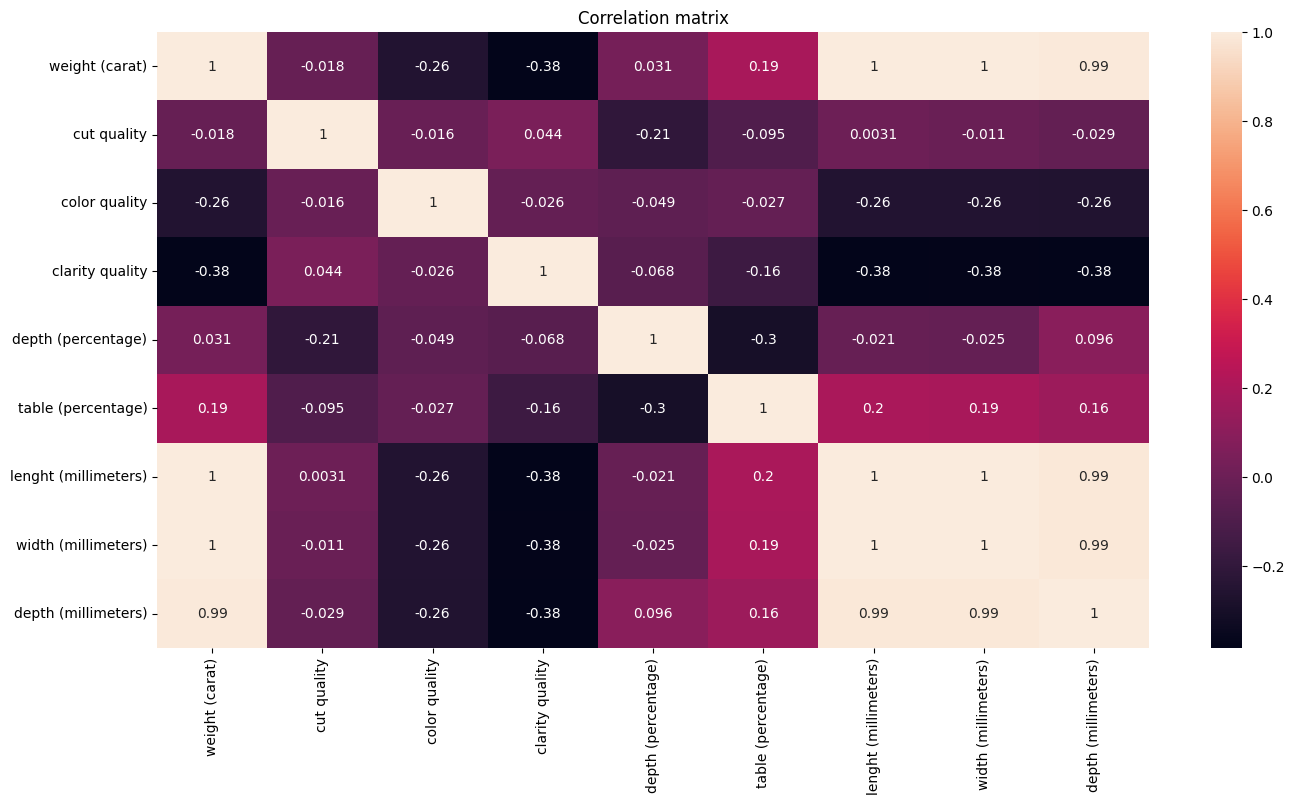

In [69]:
# Parece que lo que más influye en el precio son el tamaño ("lenght", "width" y "depth") y el peso ("weight") del diamante
# Respecto a las medidas específicas para diamantes ("depth" y "table" en %), se supone que mejorar en una suele requerir sacrificar la otra
# Eso a se debería que la "table" (parte plana superior del diamante) es más grande en los diamantes más anchos, y no en los de mayor altura ("depth")
# Asimismo, a mayor tamaño se pierde claridad (probablemente porque, con una mayor superficie, hay más probabilidad de imperfecciones)
# Hay otra correlación negativa entre la calidad del corte y el tamaño de la tabla, quizá porque cuanto mayor es la tabla más perceptibles son los cortes
# Hay que tener en cuenta al comparar que varias variables se han tipificado
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [70]:
plt.rc("figure", figsize=(6.4, 4.8))


## weight (carat), lenght (millimeters), width (millimeters), depth (millimeters) & price (dollars)

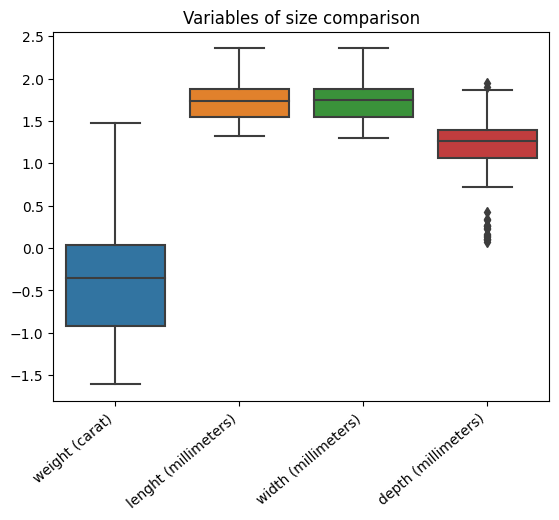

In [71]:
# Las cuatro primeras variables del título, las que vendrían a indicar el tamaño y el peso del diamante, están altísimamente correlacionadas
# Solo "depth" tiene "outliers"

items_list = ['weight (carat)', 'lenght (millimeters)', 'width (millimeters)', 'depth (millimeters)']
df_size = df_diamonds[items_list]

ax = sns.boxplot(df_size)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Variables of size comparison')
plt.show()


In [72]:
# Podemos utilizar un modelo de regresión para predecir esos "outliers" e imputarlos
# Como la correlación es tan extremadamente alta que podría decirse que son prácticamente la misma variable escalada, usamos "ridge"
q3, q1 = np.percentile(df_size['depth (millimeters)'], [75, 25])
iqr = q3 - q1

y_test = df_size[(df_size['depth (millimeters)'] > q3 + 1.5*iqr) | (df_size['depth (millimeters)'] < q1 - 1.5*iqr)]['depth (millimeters)']
y_train = df_size.drop(y_test.index)['depth (millimeters)']

X_train = df_size.drop(y_test.index)[['weight (carat)', 'lenght (millimeters)', 'width (millimeters)']]
X_test = df_size[(df_size['depth (millimeters)'] > q3 + 1.5*iqr) | (df_size['depth (millimeters)'] < q1 - 1.5*iqr)][['weight (carat)', 'lenght (millimeters)', 'width (millimeters)']]

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

df_depth = pd.DataFrame(data={'Original depth': y_test, 'Predicted depth': y_pred})

df_depth


,Original depth,Predicted depth
1249,0.269785,1.635834
4401,0.163630,1.417630
6403,1.943049,1.855833
7978,1.905088,1.873516
8174,0.101417,1.373670
10669,0.226331,1.525608
10881,0.094416,1.360703
11619,0.067659,1.391415
12992,0.264383,1.613693
19007,0.331390,1.723166


### "Outliers" tratados de "depth (millimeters)"

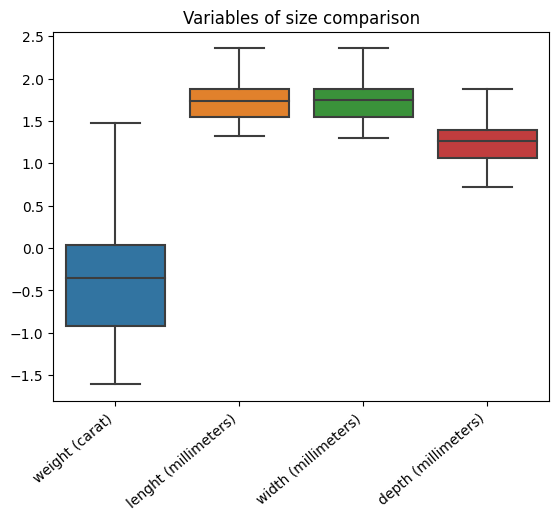

In [73]:
# Los valores atípicos de "depth" han sido neutralizados
for index in df_depth.index:
    df_diamonds.loc[index, 'depth (millimeters)'] = df_depth.loc[index, 'Predicted depth']

ax = sns.boxplot(df_diamonds[items_list])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Variables of size comparison')
plt.show()


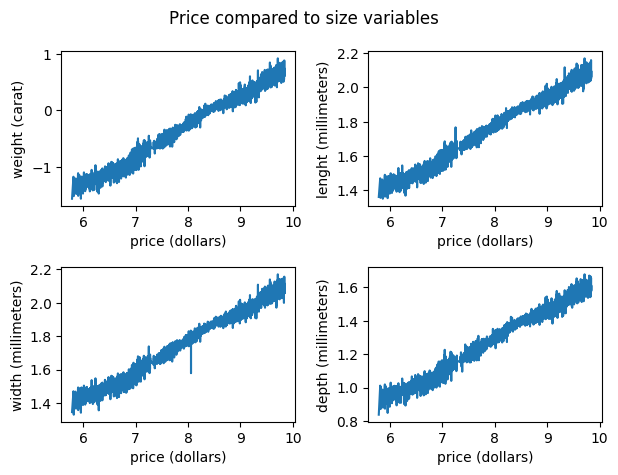

In [74]:
# Comparamos el precio con cada una de las variables relacionadas con el tamaño
# Aplicamos "errorbar=None" para que no compute los intervalos de confianza y sea más rápido
# Detectamos que, efectivamente, suben progresivamente con el precio de un modo similar
items_list.append('price (dollars)')

df_diamonds_priced = df_diamonds.join(df_price, lsuffix='_caller', rsuffix='_other')
df_diamonds_priced = df_diamonds_priced[df_diamonds_priced['price (dollars)'].notnull()]

for index, element in enumerate(items_list[:-1], 1):
    plt.subplot(2, 2, index)
    sns.lineplot(data=df_diamonds_priced, x=items_list[-1], y=element, errorbar=None)
    plt.legend('',frameon=False)
    plt.xlabel(xlabel=items_list[-1])
    plt.ylabel(ylabel=element)
plt.suptitle('Price compared to size variables')
plt.tight_layout()
plt.show()


## clarity quality, weight (carat), lenght (millimeters), width (millimeters) & depth (millimeters)

In [75]:
# La claridad del diamante (la falta de imperfecciones) tiene una importante correlación inversa (la misma) con las variable relacionadas con el tamaño
# Como las cuatro se comportan de un modo similar, para ver la tendencia las podemos simplificar en una sola
df_diamonds['size'] = (df_diamonds['weight (carat)'] 
                        + df_diamonds['lenght (millimeters)'] 
                        + df_diamonds['width (millimeters)'] 
                        + df_diamonds['depth (millimeters)']) / 4

df_diamonds['size'].unique()


array([0.67418373, 1.28281061, 1.10632522, ..., 1.322943  , 1.39106278,
       1.16253726])

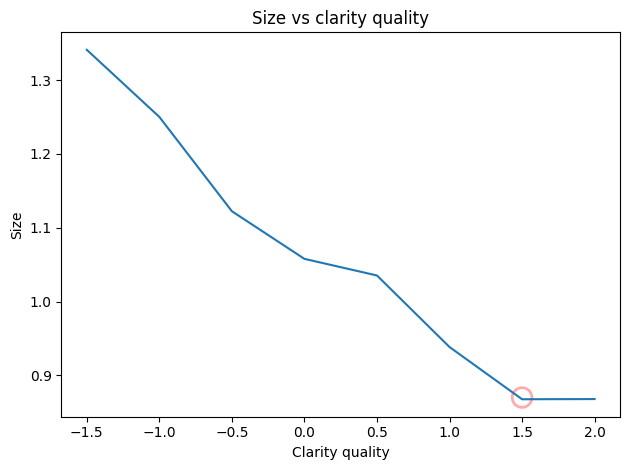

In [76]:
# Excepto con los de mayor "clarity quality" (marcado), el tamaño es cada vez más reducido
# Para futuras pruebas del modelo, cabría considerar la posibilidad de imputar los de calidad 2.0, que son pocos, al 1.5, con tal de que la tendencia se mantenga
fig, ax = plt.subplots()
ax.scatter(1.5, 0.87, s=200, edgecolor='#ff575a', lw=2, facecolor='none', alpha=0.5, zorder=1)
sns.lineplot(y=df_diamonds['size'], x=df_diamonds['clarity quality'], errorbar=None)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel(ylabel='Size')
plt.xlabel(xlabel='Clarity quality')
plt.title('Size vs clarity quality')
plt.tight_layout()
plt.show()


In [77]:
df_diamonds = df_diamonds.drop(columns='size')


## table (percentage) & depth (percentage)

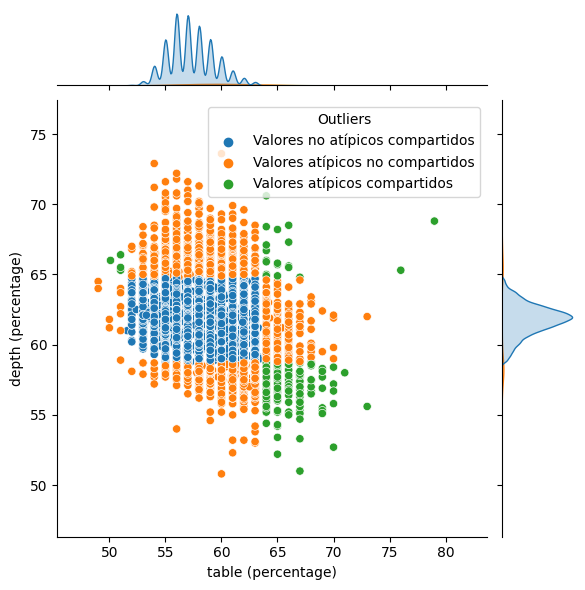

In [78]:
# La correlación más relevante de "table" es su correlación inversa con "depth (percentage)"
# Por tanto, para investigar sus valores atípicos las estudiamos a la vez
df_diamonds['Outliers'] = 'Valores no atípicos compartidos'

q3_table, q1_table = np.percentile(df_diamonds['table (percentage)'], [75, 25])
iqr_table = q3_table - q1_table
df_diamonds.loc[((df_diamonds['table (percentage)'] > q3_table + 1.5*iqr_table) | (df_diamonds['table (percentage)'] < q1_table - 1.5*iqr_table)), 'Outliers'] = 'Valores atípicos no compartidos'

q3_depth, q1_depth = np.percentile(df_diamonds['depth (percentage)'], [75, 25])
iqr_depth = q3_depth - q1_depth
df_diamonds.loc[((df_diamonds['depth (percentage)'] > q3_depth + 1.5*iqr_depth) | (df_diamonds['depth (percentage)'] < q1_depth - 1.5*iqr_depth)), 'Outliers'] = 'Valores atípicos no compartidos'

df_diamonds.loc[((df_diamonds['table (percentage)'] > q3_table + 1.5*iqr_table) | (df_diamonds['table (percentage)'] < q1_table - 1.5*iqr_table))
                & ((df_diamonds['depth (percentage)'] > q3_depth + 1.5*iqr_depth) | (df_diamonds['depth (percentage)'] < q1_depth - 1.5*iqr_depth)), 'Outliers'] = 'Valores atípicos compartidos'

sns.jointplot(data=df_diamonds, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


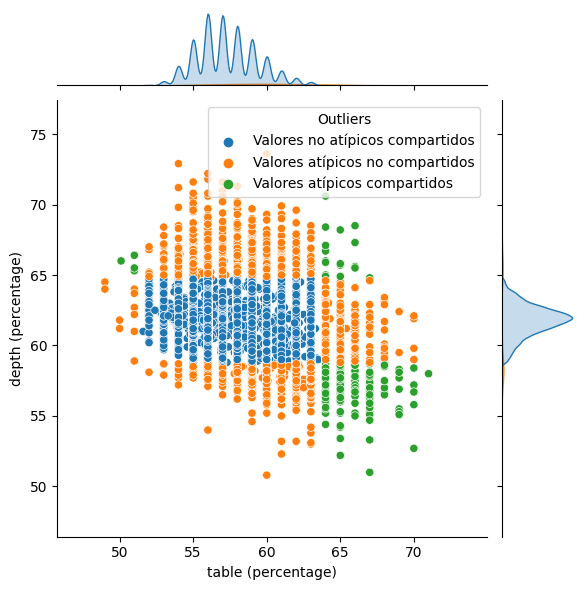

In [79]:
# Eliminamos esos cuatro valores que están muy alejados del resto del conjunto y repetimos la gráfica
df_diamonds = df_diamonds.drop(df_diamonds[df_diamonds['table (percentage)'] > 72].index)

sns.jointplot(data=df_diamonds, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


In [80]:
# Vemos que comparten algunos "outliers". Se trata de:
# a) los diamantes con mayor tabla y mayor profundidad (algunos);
# b) los diamantes con mayor tabla y menor profundidad (pocos);
# y c) los diamantes con menor tabla y mayor profundidad (muchos)
print(f"""Nº valores atípicos compartidos: {len(df_diamonds[df_diamonds['Outliers'] == 'Valores atípicos compartidos'])}
Nº valores atípicos no compartidos: {len(df_diamonds[df_diamonds['Outliers'] == 'Valores atípicos no compartidos'])}
Nº valores no atípicos compartidos: {len(df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos'])}""")


Nº valores atípicos compartidos: 212
Nº valores atípicos no compartidos: 2705
Nº valores no atípicos compartidos: 51000


### "Outliers" tratados de "depth (percentage)" y "table (percentage)"

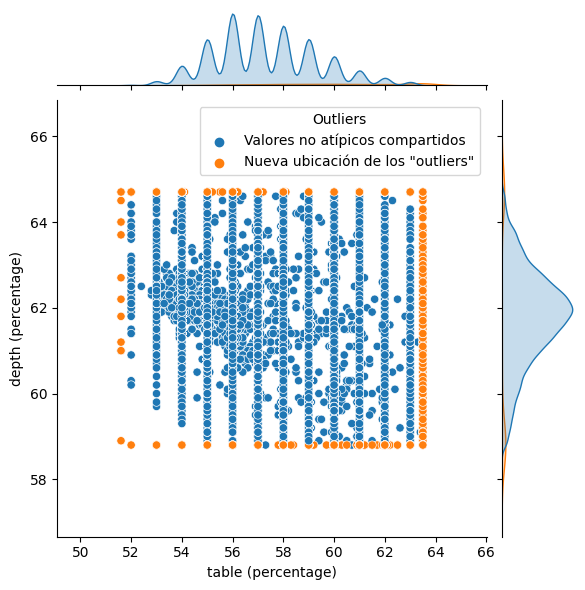

In [81]:
# Con esa información, deducimos que la correlación negativa (-0.3) se debe al peso de los "outliers" de mayor tabla y menor profundidad, que son más numerosos
# Esa correlación es especialmente importante porque es la única lo bastante alta como para vincular las dos variables, si el modelo acaba trabajando con una de ellas
# Con tal de preservar esa correlación, imputamos los valores atípicos a los máximos y mínimos de los no atípicos

max_depth = df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos']['depth (percentage)'].max()
min_depth = df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos']['depth (percentage)'].min()
max_table = df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos']['table (percentage)'].max()
min_table = df_diamonds[df_diamonds['Outliers'] == 'Valores no atípicos compartidos']['table (percentage)'].min()

df_diamonds.loc[df_diamonds['Outliers'] == 'Valores atípicos compartidos', 'Outliers'] = 'Valores atípicos no compartidos'

df_diamonds.loc[(df_diamonds['Outliers'] == 'Valores atípicos no compartidos') & (df_diamonds['depth (percentage)'] > max_depth), 'depth (percentage)'] = max_depth
df_diamonds.loc[(df_diamonds['Outliers'] == 'Valores atípicos no compartidos') & (df_diamonds['depth (percentage)'] < min_depth), 'depth (percentage)'] = min_depth
df_diamonds.loc[(df_diamonds['Outliers'] == 'Valores atípicos no compartidos') & (df_diamonds['table (percentage)'] > max_table), 'table (percentage)'] = max_table
df_diamonds.loc[(df_diamonds['Outliers'] == 'Valores atípicos no compartidos') & (df_diamonds['table (percentage)'] < min_table), 'table (percentage)'] = min_table

df_diamonds.loc[df_diamonds['Outliers'] == 'Valores atípicos no compartidos', 'Outliers'] = 'Nueva ubicación de los "outliers"'

sns.jointplot(data=df_diamonds, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


-0.3002213067867709


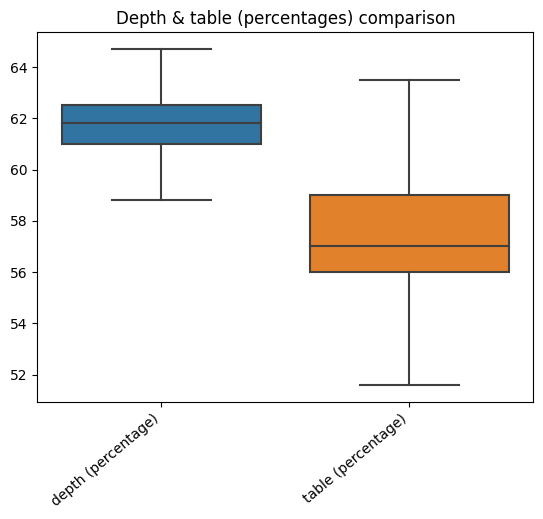

In [82]:
# La correlación inversa se mantiene en la misma cifra y ya no hay valores atípicos
df_diamonds = df_diamonds.drop(columns='Outliers')

print(df_diamonds['depth (percentage)'].corr(df_diamonds['table (percentage)']))

ax = sns.boxplot(df_diamonds[['depth (percentage)', 'table (percentage)']])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Depth & table (percentages) comparison')
plt.show()


In [83]:
# Finalmente, reducimos las cifras de ambas variables, que son muy elevadas en comparación al resto, para facilitarle el trabajo al modelo
for column in df_diamonds:
    if column == 'depth (percentage)' or column == 'table (percentage)':
        df_diamonds[column] = preprocessing.scale(df_diamonds[column], axis=0, copy=False)

df_diamonds[['depth (percentage)', 'table (percentage)']].head()


,depth (percentage),table (percentage)
0,0.514602,0.260162
1,0.751928,-0.665988
2,0.039951,0.723237
3,1.147471,-0.202913
4,0.435494,0.723237


## cut quality & table (percentage)

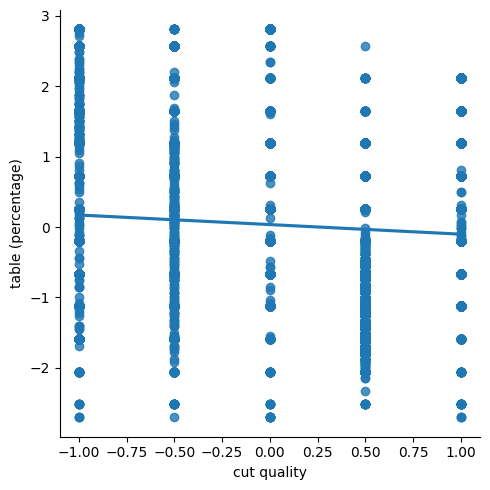

In [84]:
# Las variables "cut quality" y "table (percentage)", que es el tamaño de la parte plana en relación con su diámetro, tienen una alta correlación inversa
# Notamos que los valores de "table (percentage)" parecen concentrarse en un punto a medida que aumenta la calidad hasta desplazarse finalmente hacia valores negativos con los mejor cortados
# Con lo visto en el análisis univariante de "cut quality" y en la gráfica, hacemos esta suposición:
# que haya pocos valores de calidad menor influye en que la concentración de los números más altos sea superior, lo que hace caer la correlación
sns.lmplot(data=df_diamonds, x='cut quality', y='table (percentage)')
plt.show()


In [85]:
# Queremos fabricar más valores de "table (percentage)"" que tengan -1.0 de "cut quality" para comprobar si esa suposición es cierta
# Para ello, como no queremos que el resultado se aleje mucho la predicción de lo que ya existe y disponemos de pocos datos, iteraremos con un modelo de k vecinos
# Para asegurarnos, procuraremos que el número de valores resultantes se aceque a los 20000 que tiene el corte de mayor calidad
lower_cut = df_diamonds[df_diamonds['cut quality'] == -1.0]

new_cut = list(df_diamonds['cut quality'])
new_table = list(df_diamonds['table (percentage)'])
for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(lower_cut.drop(columns='table (percentage)'), lower_cut['table (percentage)'], train_size=0.6, random_state=random.randint(1, 10000))
    vecinos = KNeighborsRegressor()
    vecinos.fit(X_train, y_train)
    y_pred = vecinos.predict(X_test).tolist()
    new_cut += [-1.0] * len(y_pred)
    new_table += y_pred
cut_table_comparison = pd.DataFrame({'cut quality': new_cut, 'table (percentage)': new_table})

print(f"Nº de valores -1.0 originales: {len(df_diamonds[df_diamonds['cut quality'] == -1.0])}")
print(f"Nº de valores -1.0 tras la fabricación: {len(cut_table_comparison[cut_table_comparison['cut quality'] == -1.0])}")


Nº de valores -1.0 originales: 4904
Nº de valores -1.0 tras la fabricación: 63764


                    cut quality  table (percentage)
cut quality            1.000000           -0.250857
table (percentage)    -0.250857            1.000000


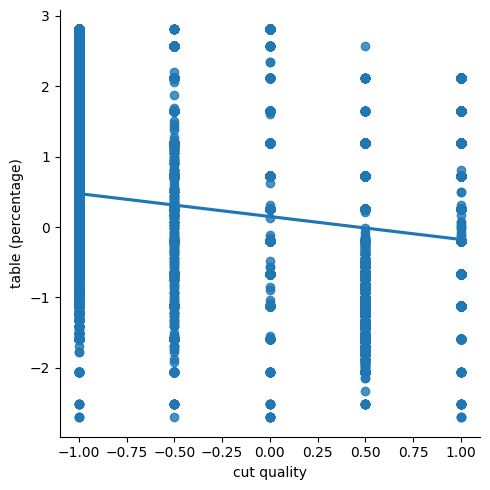

In [86]:
# Hemos creado muchos valores artificialmente, y, sin embargo, no hay grandes cambios
# No se alteran excesivamente la correlación ni la recta de regresión: la suposición no es cierta
print(cut_table_comparison.corr())

sns.lmplot(data=cut_table_comparison, x='cut quality', y='table (percentage)')
plt.show()


# Observaciones finales

In [87]:
# Los números han quedado pequeños; salvo la "target", ninguna columna tiene valores excesivamente altos (todos están alrededor del 0)
df_diamonds.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
0,-1.203973,1.0,1.5,-1.0,0.514602,0.260162,1.460938,1.453953,0.985817
1,0.009950,0.5,1.0,1.0,0.751928,-0.665988,1.859418,1.865629,1.396245
2,-0.328504,0.5,0.5,-0.0,0.039951,0.723237,1.742219,1.747459,1.264127
3,0.076961,-0.5,0.0,-1.0,1.147471,-0.202913,1.877937,1.871802,1.415853
4,-1.021651,1.0,0.0,0.5,0.435494,0.723237,1.504077,1.515127,1.036737


In [88]:
# Se han borrado 23 filas respecto a las 53940 iniciales
df_diamonds.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53917 entries, 0 to 53939
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weight (carat)        53917 non-null  float64
 1   cut quality           53917 non-null  float64
 2   color quality         53917 non-null  float64
 3   clarity quality       53917 non-null  float64
 4   depth (percentage)    53917 non-null  float64
 5   table (percentage)    53917 non-null  float64
 6   lenght (millimeters)  53917 non-null  float64
 7   width (millimeters)   53917 non-null  float64
 8   depth (millimeters)   53917 non-null  float64
dtypes: float64(9)
memory usage: 4.1 MB


In [89]:
# Todas las columnas son numéricas y no hay ceros en las variables relacionadas con el tamaño
df_diamonds.describe()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
count,53917.000000,53917.000000,53917.000000,53917.000000,5.391700e+04,5.391700e+04,53917.000000,53917.000000,53917.000000
mean,-0.395089,0.252573,0.202867,0.025586,-1.515259e-15,2.596156e-15,1.727226,1.727822,1.245201
std,0.584826,0.662428,0.850581,0.823609,1.000009e+00,1.000009e+00,0.193733,0.192315,0.193830
min,-1.609438,-1.000000,-1.500000,-1.500000,-2.333305e+00,-2.703518e+00,1.316408,1.302913,0.722706
25%,-0.916291,-0.500000,-0.500000,-0.500000,-5.929171e-01,-6.659882e-01,1.549688,1.551809,1.068153
50%,-0.356675,0.500000,0.000000,0.000000,3.995115e-02,-2.029132e-01,1.740466,1.742219,1.261298
75%,0.039221,1.000000,1.000000,0.500000,5.937109e-01,7.232368e-01,1.877937,1.877937,1.396245
max,1.472488,1.000000,1.500000,2.000000,2.334099e+00,2.807074e+00,2.355178,2.355178,1.873516


In [90]:
# No hay duplicados
df_diamonds[df_diamonds.duplicated()]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
1066,-0.693147,-1.0,1.0,-0.5,1.780339,-0.202913,1.617406,1.607436,1.166271
1218,0.231112,0.5,1.0,1.0,-0.513809,-0.202913,1.945910,1.943049,1.451614
2524,-0.693147,-1.0,1.0,-0.5,1.938556,0.723237,1.615420,1.603420,1.166271
2746,-0.843970,0.5,0.0,0.5,0.119060,-1.129063,1.576915,1.581038,1.098612
3225,-1.078810,1.0,1.0,-0.5,-1.937762,0.260162,1.523880,1.515127,0.996949
...,...,...,...,...,...,...,...,...,...
53617,0.009950,1.0,0.5,-1.0,-1.700437,0.723237,1.885553,1.874874,1.363537
53620,-0.510826,1.0,1.5,-1.0,0.198168,-0.202913,1.691939,1.677097,1.205971
53706,1.101940,-1.0,-1.0,-1.0,1.701230,1.186312,2.203869,2.198335,1.752672
53769,0.000000,-0.5,0.5,0.5,-2.333305,2.575537,1.884035,1.867176,1.337629


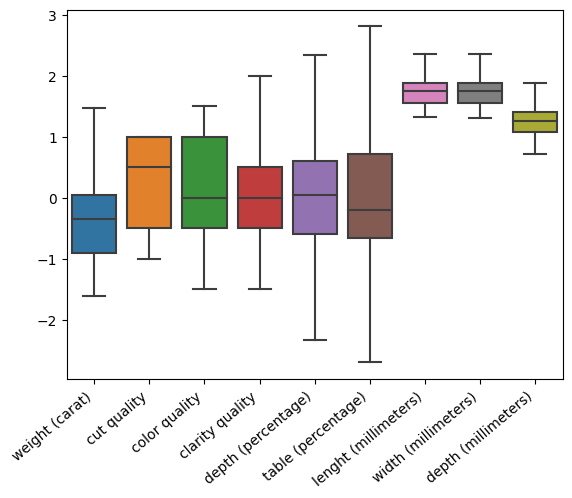

In [91]:
# No hay valores atípicos
ax = sns.boxplot(df_diamonds)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()


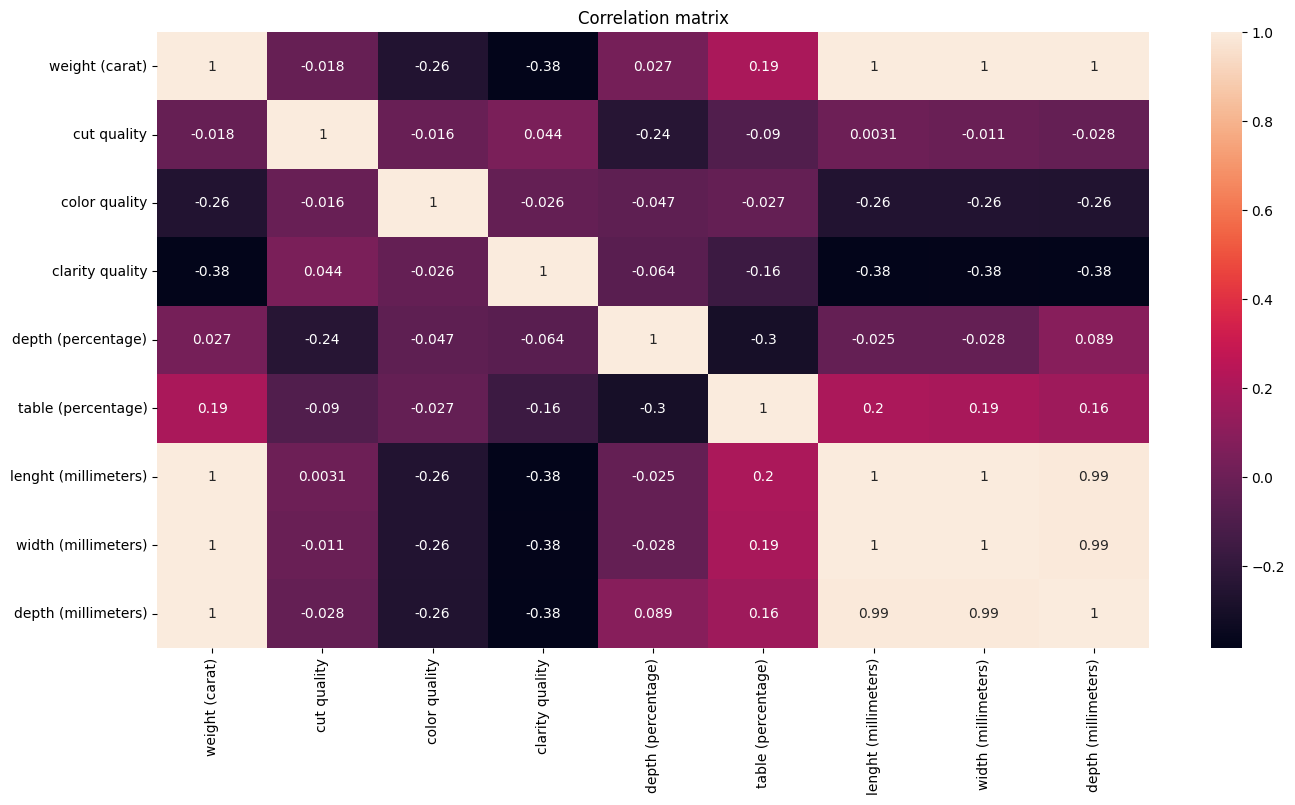

In [92]:
# La correlación ha cambiado un poco (por ejemplo, algunos valores se han convertido en 1) debido a la tipificación de los datos
# La tendencia general es similar y se han incorporado las variables que eran categóricas
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [93]:
plt.rc("figure", figsize=(6.4, 4.8))


In [94]:
# El "dataframe" está preparado para el modelaje. Lo exportamos
df_diamonds = df_diamonds.join(df_price, lsuffix='_caller', rsuffix='_other')
df_diamonds.to_csv(r'..\data\processed\processed_diamonds(competition)_1.csv', index=False)
